# ML Pipeline

## Data Preparation

In [161]:
from utils import initialize_bucket, plot_importance

import pandas as pd
import numpy as np
import re
import ast

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import KFold, cross_val_score,cross_validate
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler, Normalizer

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import pickle
import json




### Extracting refined dataset from Google Storage Bucket

In [162]:
credentials_path = 'datascience-capstone-project-05b1642f45c3.json'

In [163]:
client, bucket = initialize_bucket(credentials_path,'storage-barsianize')

path = "gs://storage-barsianize/refined/base_dataset.csv"
base_dataset =  pd.read_csv(path, index_col=0)
df = base_dataset.copy()

In [164]:
df.head()

,Papel,Tipo,Empresa,Setor,Subsetor,dy_label,cotacao_rel,cotacao_mean_median_ratio,cotacao_std,cotacao_spread,...,pa_mean_median_ratio,pcg_mean_median_ratio,pebit_mean_median_ratio,pacl_mean_median_ratio,evebit_mean_median_ratio,mrgebit_mean_median_ratio,mrgliq_mean_median_ratio,roic_mean_median_ratio,liqc_mean_median_ratio,divbpatr_mean_median_ratio
0,ABCB4,PN N2,ABC Brasil PN N2,Intermediários Financeiros,Bancos,0.0484,0.932271,1.041918,1.219257,0.236761,...,1.063461,1.176368,1.056614,1.120182,1.149613,1.236078,0.983099,1.009125,1.106529,0.761111
0,ABCB4,PN N2,ABC Brasil PN N2,Intermediários Financeiros,Bancos,0.0557,0.541638,0.992951,2.386490,0.554539,...,1.063461,1.176368,1.056614,1.120182,1.149613,1.236078,0.983099,1.009125,1.106529,0.761111
0,ABCB4,PN N2,ABC Brasil PN N2,Intermediários Financeiros,Bancos,0.0643,1.482172,1.040667,3.371532,0.804220,...,1.063461,1.176368,1.056614,1.120182,1.149613,1.236078,0.983099,1.009125,1.106529,0.761111
0,ABCB4,PN N2,ABC Brasil PN N2,Intermediários Financeiros,Bancos,0.0308,1.169838,1.021558,3.690056,0.761940,...,1.063461,1.176368,1.056614,1.120182,1.149613,1.236078,0.983099,1.009125,1.106529,0.761111
0,ABCB4,PN N2,ABC Brasil PN N2,Intermediários Financeiros,Bancos,0.0466,1.377959,0.967302,3.944564,0.737458,...,1.063461,1.176368,1.056614,1.120182,1.149613,1.236078,0.983099,1.009125,1.106529,0.761111


#### Defining Label

In [165]:
df.isna().sum().sort_values(ascending=False)

Papel                         0
liqc_mean                     0
roe_mean_median_ratio         0
roe_std                       0
roe_spread                    0
                             ..
pcg_spread                    0
pcg_spread_rel_now            0
pebit                         0
pebit_rel                     0
divbpatr_mean_median_ratio    0
Length: 159, dtype: int64

#### Adjust data types

In [166]:
df.columns

Index(['Papel', 'Tipo', 'Empresa', 'Setor', 'Subsetor', 'dy_label',
       'cotacao_rel', 'cotacao_mean_median_ratio', 'cotacao_std',
       'cotacao_spread',
       ...
       'pa_mean_median_ratio', 'pcg_mean_median_ratio',
       'pebit_mean_median_ratio', 'pacl_mean_median_ratio',
       'evebit_mean_median_ratio', 'mrgebit_mean_median_ratio',
       'mrgliq_mean_median_ratio', 'roic_mean_median_ratio',
       'liqc_mean_median_ratio', 'divbpatr_mean_median_ratio'],
      dtype='object', length=159)

#### Numerical encoding for object variables

In [167]:
features_to_drop = ['Data_ult_cot','papel','date','Data_ult_cot_year','year']
df.drop(features_to_drop, axis=1, inplace=True)

In [168]:
df_objects = df.select_dtypes('object').copy()
df_objects = df_objects.drop(['Empresa','Papel'], axis=1)
object_cols = df_objects.columns
print(object_cols)

Index(['Tipo', 'Setor', 'Subsetor'], dtype='object')


In [169]:
for col in object_cols:
    df[col] = df_objects[col].astype('category').cat.codes

df.dtypes

Papel                          object
Tipo                             int8
Empresa                        object
Setor                            int8
Subsetor                         int8
                               ...   
mrgebit_mean_median_ratio     float64
mrgliq_mean_median_ratio      float64
roic_mean_median_ratio        float64
liqc_mean_median_ratio        float64
divbpatr_mean_median_ratio    float64
Length: 154, dtype: object

#### Spliting data into training a test data

In [170]:
X.max().sort_values(ascending=False)

liq2m_spread_rel_now        1.872418e+11
liq2m_mean_median_ratio     1.202413e+11
evebit_std                  4.750459e+07
pebit_std                   2.399578e+07
evebit_mean_median_ratio    1.812493e+07
                                ...     
roe_median                  1.952950e+00
roic                        1.257500e+00
roic_mean                   6.538167e-01
roic_median                 6.519000e-01
dy_median                   1.560000e-01
Length: 151, dtype: float64

features X_train: 151
features X_test: 151
R2 score: -30.04009780817603
Mean squared error: 0.3073206416355874
test score: 0.2716041190908087 
train score: 0.9931090533922766


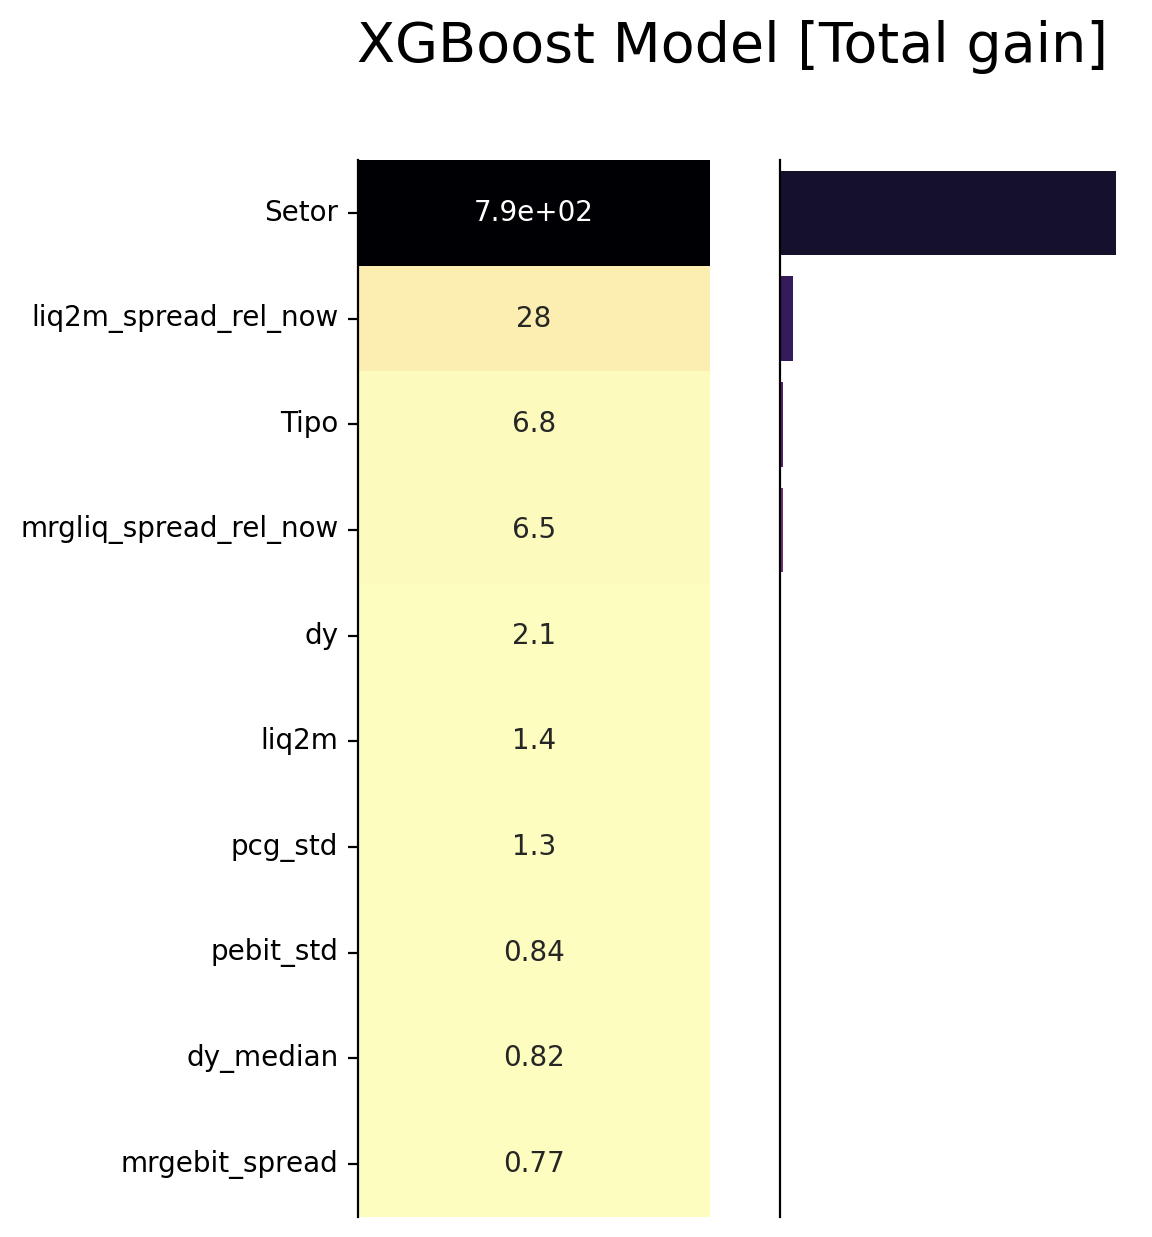

In [178]:
# using the standard scaler to standardize the data
# scaler = StandardScaler()
scaler = Normalizer()

# separating the train and target features
X = df.drop(['Papel','Empresa','dy_label'], axis=1)
y = df['dy_label']

# train and test datasets split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# standardization of the dataset
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# check the shape of the train and test datasets
print(f'features X_train: {len(X_train[1])}\nfeatures X_test: {len(X_test[1])}')

# define the XGBoost model with your preferred hyperparameters
xgb_model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)

# define the cross-validation method (e.g. KFold with 5 folds)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# define the evaluation metrics (r2 score and mean squared error)
scoring = {'r2': make_scorer(r2_score), 'mse': make_scorer(mean_squared_error)}

# perform cross-validation and get the scores
scores = cross_validate(xgb_model, X, y, cv=cv, scoring=scoring)
xgb_model.fit(X_train, y_train)
xgb_model_pred_train=xgb_model.predict(X_train)
xgb_model_pred_test=xgb_model.predict(X_test)

print('R2 score:', np.mean(scores['test_r2']))
print('Mean squared error:', np.mean(scores['test_mse']))

# # define your cross validation strategy
# cv = KFold(n_splits=5, shuffle=True, random_state=42)

# # evaluate the XGBoost model with cross validation
# xgscore = cross_val_score(xgb_model, X, y, cv=cv, scoring=['neg_mean_squared_error','r2_score'])

# # print the mean and standard deviation of the cross validation scores
# print('Cross Validation Scores:')
# print('Mean:', np.mean(xgscore))
# print('Std:', np.std(xgscore))

# printing cross validation results
# print(f'XGBoost cross val score: {scoring}')

# # analysing train and test data results
train_score_xgb_model =  r2_score(y_train, xgb_model_pred_train)
test_score_xgb_model = r2_score(y_test, xgb_model_pred_test)
# printing r2 scores of training and test
print(f'test score: {test_score_xgb_model} \ntrain score: {train_score_xgb_model}')

# getting the most important features
dict_importance = xgb_model.get_booster().get_score(importance_type="total_gain")
d={}
# cleanse the data
for index, value in dict_importance.items():
    d[X.columns[int(index[1:])]] = value
# transforming data to a dataframe
most_important_XGBoost_review = pd.DataFrame(d, index=['Total gain']).T
most_important_XGBoost_review = most_important_XGBoost_review[['Total gain']].sort_values(ascending=False, by='Total gain')

# plot most important features
plot_importance(most_important_XGBoost_review, 'Total gain', 'XGBoost Model [Total gain]')

In [172]:
most_important_XGBoost_review.iloc[:25].index

Index(['Setor', 'liq2m_spread_rel_now', 'Tipo', 'mrgliq_spread_rel_now', 'dy',
       'liq2m', 'pcg_std', 'pebit_std', 'dy_median', 'mrgebit_spread',
       'pl_median', 'cotacao_rel', 'c5y_mean_median_ratio',
       'pacl_spread_rel_now', 'dy_spread_rel_now', 'pebit', 'dy_std',
       'divbpatr_median', 'roic', 'pl', 'pebit_median', 'patrliq_rel', 'roe',
       'roic_rel', 'pacl_rel'],
      dtype='object')

features X_train: 20
features X_test: 20
R2 score: -31.714399506023547
Mean squared error: 0.23770952539122633
test score: 0.4284044329887382 
train score: 0.9914141263315422


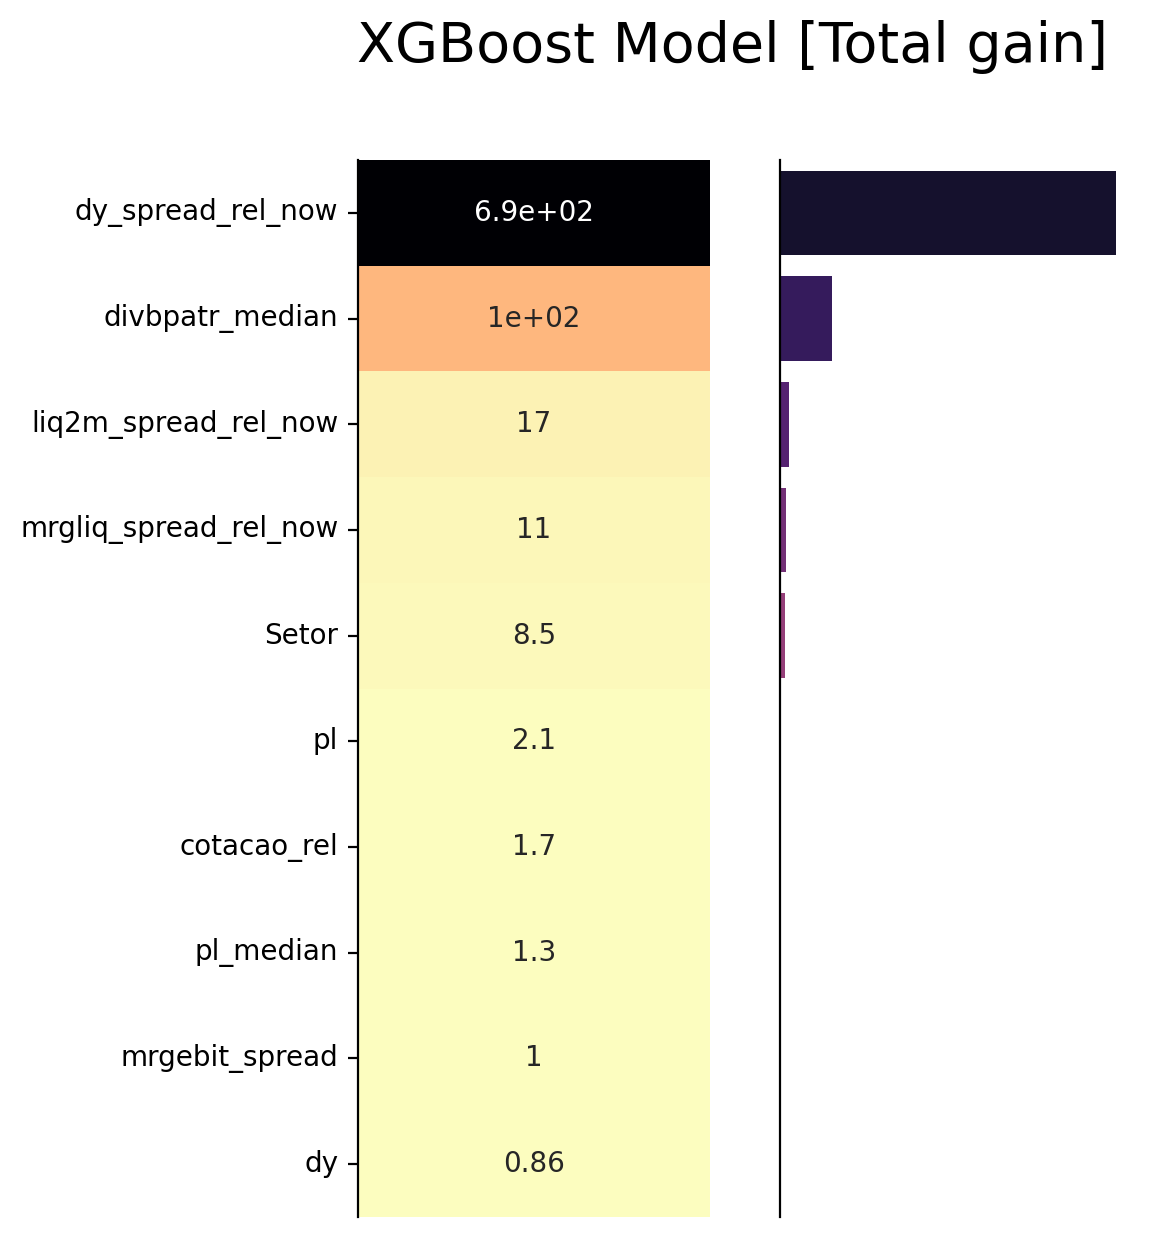

In [176]:
# using the standard scaler to standardize the data
# scaler = StandardScaler()
scaler = Normalizer()

# separating the train and target features
X = df[most_important_XGBoost_review.iloc[:20].index]
y = df['dy_label']

# train and test datasets split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# standardization of the dataset
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# check the shape of the train and test datasets
print(f'features X_train: {len(X_train[1])}\nfeatures X_test: {len(X_test[1])}')

# define the XGBoost model with your preferred hyperparameters
xgb_model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)

# define the cross-validation method (e.g. KFold with 5 folds)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# define the evaluation metrics (r2 score and mean squared error)
scoring = {'r2': make_scorer(r2_score), 'mse': make_scorer(mean_squared_error)}

# perform cross-validation and get the scores
scores = cross_validate(xgb_model, X, y, cv=cv, scoring=scoring)
xgb_model.fit(X_train, y_train)
xgb_model_pred_train=xgb_model.predict(X_train)
xgb_model_pred_test=xgb_model.predict(X_test)

print('R2 score:', np.mean(scores['test_r2']))
print('Mean squared error:', np.mean(scores['test_mse']))

# # define your cross validation strategy
# cv = KFold(n_splits=5, shuffle=True, random_state=42)

# # evaluate the XGBoost model with cross validation
# xgscore = cross_val_score(xgb_model, X, y, cv=cv, scoring=['neg_mean_squared_error','r2_score'])

# # print the mean and standard deviation of the cross validation scores
# print('Cross Validation Scores:')
# print('Mean:', np.mean(xgscore))
# print('Std:', np.std(xgscore))

# printing cross validation results
# print(f'XGBoost cross val score: {scoring}')

# # analysing train and test data results
train_score_xgb_model =  r2_score(y_train, xgb_model_pred_train)
test_score_xgb_model = r2_score(y_test, xgb_model_pred_test)
# printing r2 scores of training and test
print(f'test score: {test_score_xgb_model} \ntrain score: {train_score_xgb_model}')

# getting the most important features
dict_importance = xgb_model.get_booster().get_score(importance_type="total_gain")
d={}
# cleanse the data
for index, value in dict_importance.items():
    d[X.columns[int(index[1:])]] = value
# transforming data to a dataframe
most_important_XGBoost_review = pd.DataFrame(d, index=['Total gain']).T
most_important_XGBoost_review = most_important_XGBoost_review[['Total gain']].sort_values(ascending=False, by='Total gain')

# plot most important features
plot_importance(most_important_XGBoost_review, 'Total gain', 'XGBoost Model [Total gain]')

### Building a Machine Learning Pipeline 

In [173]:
def build_pipelines(regressors):
    pipelines = {}
    for algorithm,regressor in regressors.items():
        pipeline = Pipeline([
            ('reg',regressor)
        ])
        pipelines[algorithm] = pipeline

    return pipelines

In [174]:

def build_models(classifiers,parameters_dict):
    pipelines = build_pipelines(classifiers)

    cvs = {}
    
    for algorithm,parameters in parameters_dict.items():
        # create grid search object
        cv = GridSearchCV(pipelines[algorithm], param_grid=parameters)
        cvs[algorithm] = cv
    
    return cvs

In [175]:
def display_and_store_results(cv,y_test,y_pred,algorithm):
    
    columns = y_test.columns
    classification_reports = []
    for i, col in enumerate(columns):
        print(col)
        classif_report = classification_report(y_test[col], y_pred[:,i])
        print(classif_report)
        classification_reports.append(classif_report)
        print('___________________________________')
        
    print("\nBest Parameters:", cv.best_params_)
    print('##################################')

    performance = {
        'algorithm':algorithm,
        'best_params':cv.best_params_,
        'class':classification_reports
    }

    patch = '../data/03_models/out/'
    filename = patch + algorithm

    json.dump(performance, open(filename+'_results.json', 'w'))   
    pickle.dump(cv.best_estimator_, open(filename+'.pkl', 'wb'))



    

def main():
    X, y = load_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3)

    # reading the training parameters for grid search
    with open('../data/03_models/in/params.json') as json_file:
        parameters = json.load(json_file)
        for key_1, value_1 in params.items():
            for key_2, value_2 in value_1.items():
                parameters[key_1][key_2] = ast.literal_eval(value_2)

    # defining which classifiers are going to be used
    regressors = {
        'LGBMRegressor':LGBMRegressor(),
        'XGBRegressor':XGBRegressor(),
        'RandomForestRegressor':RandomForestRegressor()
    }

    models = build_models(regressors,parameters)

    for algorithm, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        display_and_store_results(model, y_test, y_pred, algorithm)

    return models


models  = main()

NameError: name 'load_data' is not defined

In [ ]:
regressors = {
        'LGBMRegressor':LGBMRegressor(),
        'XGBRegressor':XGBRegressor(),
        'RandomForestRegressor':RandomForestRegressor()
    }

with open('data/params.json') as json_file:
        parameters = json.load(json_file)
        for key_1, value_1 in parameters.items():
            for key_2, value_2 in value_1.items():
                parameters[key_1][key_2] = ast.literal_eval(value_2)

models = build_models(regressors,parameters)